## Compute variance per site dist for each pair of tips

In [2]:
# check conda enviornment
import sys; sys.prefix

'/home/scarlet/miniconda3/envs/env20230724'

In [3]:
from pathlib import Path
import toytree
import toyplot, toyplot.svg
import numpy as np
import pandas as pd
import itertools
import ipcoal
from concurrent.futures import ProcessPoolExecutor

In [30]:
# make directory for saving figures
#Path("./nb9_output/").mkdir(exist_ok=True)

- Simulate linked loci with lengths of 1KB, 10KB and 100KB in ipcoal
- Find node distance of each gene tree
- Record weights as `length` of locus in ipcoal output iter model.df
- Create weighted lengths = node distance * weights 
- Final heatmap of var per site dist for each pair of tips = Use np.var(X, weights=[100, 200...]) 

### Starting/correct tree topologies - BALANCED TREES

In [238]:
# get an ultrametric balanced tree
BALTREE = toytree.rtree.baltree(8, treeheight=1e6)
EDGES1 = [2,3,9,6,7,12]
EDGES2 = [2,3,9,10,6,7,12,13]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000
NAME_ORDER = sorted(BALTREE.get_tip_labels())[::-1]
NAME_ORDER     # use when tree.draw(fixed_order=NAME_ORDER)


['r7', 'r6', 'r5', 'r4', 'r3', 'r2', 'r1', 'r0']

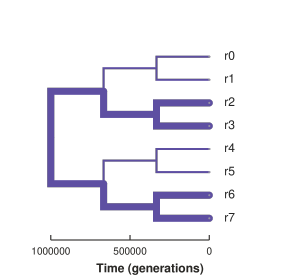

In [239]:
# VARY NE
# set parameters on the species tree
baltree_2_ne = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_ne.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_ne = baltree_2_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES2}, default=NE_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("gt", default=GT_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_ne})

# convert edge lens to units of generations.
baltree_2_ne = baltree_2_ne.set_node_data("dist", {i: i.tg for i in baltree_2_ne})

# show data
baltree_2_ne.get_node_data()

kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt", fixed_order = NAME_ORDER
)

# canvas for tree
c, a, m = baltree_2_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb9_output/tree-bal-ne-gunits.svg")
c

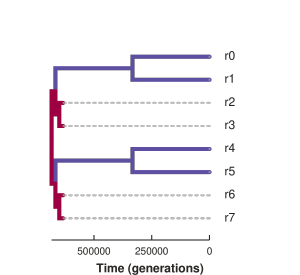

In [240]:
# VARY GT
baltree_2_gt = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_gt.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_gt = baltree_2_gt.set_node_data("Ne", default=NE_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES2}, default=GT_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_gt})

# convert dist to units of generations. Draw and show data
baltree_2_gt = baltree_2_gt.set_node_data("dist", {i: i.tg for i in baltree_2_gt})
baltree_2_gt.get_node_data()

kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt", fixed_order = NAME_ORDER
)
c, a, m = baltree_2_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb9_output/tree-bal-gt-gunits.svg")
c

### Starting/correct tree topologies - IMBALANCED TREES

In [230]:
# get an ultrametric imbalanced tree
IMBTREE = toytree.rtree.imbtree(8, treeheight=1e6)
EDGES = [3, 4, 10, 11]
# EDGES = [0, 1, 2, 6, 7, 8, 9, 13, 14]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000
NAME_ORDER = sorted(IMBTREE.get_tip_labels())[::-1]
NAME_ORDER     # use when tree.draw(fixed_order=NAME_ORDER)

['r7', 'r6', 'r5', 'r4', 'r3', 'r2', 'r1', 'r0']

In [231]:
# set parameters on the species tree
imbtree_ne = IMBTREE.copy()
imbtree_ne = imbtree_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES}, default=NE_DEFAULT)
imbtree_ne = imbtree_ne.set_node_data("gt", default=GT_DEFAULT)
imbtree_ne = imbtree_ne.set_node_data("tg", {i: i.dist / i.gt for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in imbtree_ne})

# convert edge lens to units of generations.
imbtree_ne = imbtree_ne.set_node_data("dist", {i: i.tg for i in imbtree_ne})

# show data
imbtree_ne.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,1.164153e-10,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02
1,1,r1,1.164153e-10,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02
2,2,r2,1.164153e-10,2.857143e+05,NaN,500000.0,1,0.002,0.285714,2.857143e+05,571.428571,0.000006,0.02
3,3,r3,0.000000e+00,4.285714e+05,NaN,10000000.0,1,0.040,0.021429,4.285714e+05,17142.857143,0.000171,0.40
4,4,r4,0.000000e+00,5.714286e+05,NaN,10000000.0,1,0.040,0.028571,5.714286e+05,22857.142857,0.000229,0.40
5,5,r5,1.164153e-10,7.142857e+05,NaN,500000.0,1,0.002,0.714286,7.142857e+05,1428.571429,0.000014,0.02
6,6,r6,0.000000e+00,8.571429e+05,NaN,500000.0,1,0.002,0.857143,8.571429e+05,1714.285714,0.000017,0.02
7,7,r7,0.000000e+00,1.000000e+06,NaN,500000.0,1,0.002,1.000000,1.000000e+06,2000.000000,0.000020,0.02
8,8,,1.428571e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02
9,9,,2.857143e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02


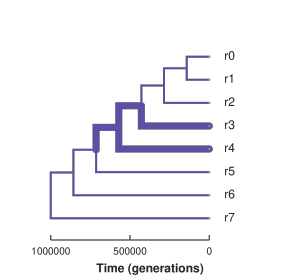

In [241]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt", fixed_order = NAME_ORDER
)
c, a, m = imbtree_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb9_output/tree-imb-ne-gunits.svg")
c

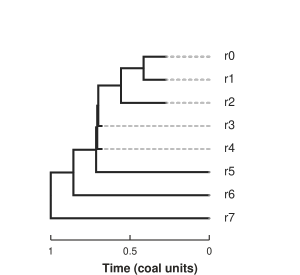

In [249]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = imbtree_ne.set_node_data("dist", {i: i.tc for i in imbtree_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb9_output/tree-imb-ne-cunits.svg")
c

In [242]:
imbtree_gt = IMBTREE.copy()
imbtree_gt = imbtree_gt.set_node_data("Ne", default=NE_DEFAULT)
imbtree_gt = imbtree_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES}, default=GT_DEFAULT)
imbtree_gt = imbtree_gt.set_node_data("tg", {i: i.dist / i.gt for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in imbtree_gt})

# convert dist to units of generations. Draw and show data
imbtree_gt = imbtree_gt.set_node_data("dist", {i: i.tg for i in imbtree_gt})
imbtree_gt.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,2.714286e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02
1,1,r1,2.714286e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02
2,2,r2,2.714286e+05,2.857143e+05,NaN,500000.0,1,0.002,0.285714,2.857143e+05,571.428571,5.714286e-06,0.02
3,3,r3,6.785714e+05,2.142857e+04,NaN,500000.0,20,0.002,0.021429,2.142857e+04,42.857143,4.285714e-07,0.02
4,4,r4,6.785714e+05,2.857143e+04,NaN,500000.0,20,0.002,0.028571,2.857143e+04,57.142857,5.714286e-07,0.02
5,5,r5,1.164153e-10,7.142857e+05,NaN,500000.0,1,0.002,0.714286,7.142857e+05,1428.571429,1.428571e-05,0.02
6,6,r6,0.000000e+00,8.571429e+05,NaN,500000.0,1,0.002,0.857143,8.571429e+05,1714.285714,1.714286e-05,0.02
7,7,r7,0.000000e+00,1.000000e+06,NaN,500000.0,1,0.002,1.000000,1.000000e+06,2000.000000,2.000000e-05,0.02
8,8,,4.142857e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02
9,9,,5.571429e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02


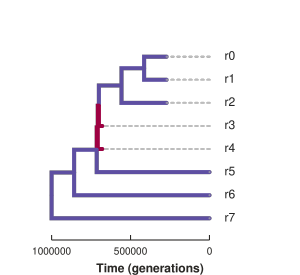

In [243]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt", fixed_order = NAME_ORDER,
)
c, a, m = imbtree_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb9_output/tree-imb-gt-gunits.svg")
c

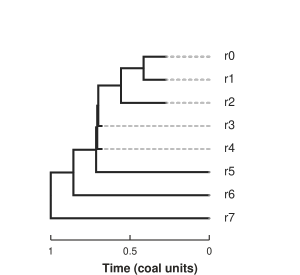

In [248]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = imbtree_gt.set_node_data("dist", {i: i.tc for i in imbtree_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb9_output/tree-imb-gt-cunits.svg")
c

### Simulation functions

In [12]:
def one_batch_sim(tree, nloci, nsites, nthreads, seed, infer):
    """Return two dataframes with genealogies and gene trees, respectively."""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    if (nsites == 1) or (not infer):
        raxdf = None
    else:
        raxdf = ipcoal.phylo.infer_raxml_ng_trees(
            model, nthreads=nthreads, nproc=1, nworkers=1, do_not_autoscale_threads=True)
    return model.df, raxdf

In [13]:
def batch_sims(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, infer: bool = True):    
    """Return dataframes from simulations and tree inferences distributed to run in parallel"""
    if nloci == 1:
        return one_batch_sim(tree, nloci, nsites, nthreads, None, infer)

    # not perfect
    nloci_per = int(nloci / njobs)
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(njobs):
            rasyncs[i] = pool.submit(one_batch_sim, *(tree, nloci_per, nsites, nthreads, None, infer))
    gdata = []
    rdata = []
    for i in range(njobs):
        gdf, rdf = rasyncs[i].result()
        gdf.locus += i * nloci_per
        gdata.append(gdf)
        if rdf is not None:
            rdf.locus += i * nloci_per
            rdata.append(rdf)
    gdata = pd.concat(gdata, ignore_index=True)
    if rdata:
        rdata = pd.concat(rdata, ignore_index=True)
    return gdata, rdata

In [14]:
def one_concat(tree, nloci, nsites, nthreads, seed: int = None, nworkers: int = None):
    """Infer a concatenation tree"""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    raxtree = ipcoal.phylo.infer_raxml_ng_tree(
            model, nthreads=nthreads, nworkers=nworkers, do_not_autoscale_threads=True)
    return raxtree

In [15]:
def batch_concat(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, nreps: int = 10):
    """Return a list of inferred concatenation trees"""
    if nloci == 1:
        return one_batch_sim(tree, nloci, nsites, nthreads, None)

    # not perfect
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(nreps):
            rasyncs[i] = pool.submit(one_concat, *(tree, nloci, nsites, nthreads, None))
    return [i.result() for i in rasyncs.values()]

In [16]:
def iter_first_genealogies(model_df: pd.DataFrame):
    for _, df in model_df.groupby("locus"):
        yield toytree.tree(df.iloc[0, 6])

In [210]:
def plot_matrix(
    dat: np.ndarray,
    domain_min: float = None,
    domain_max: float = None,
    cmap: str = "BlueRed",
    gap: float = 0,
    mask_diagonal: bool = False,
    color_bar: bool = False,
) -> "Canvas":
    """Return a matrix heatmap """
    
    # get min and max of the off-diagonal elements
    if mask_diagonal:
        dat = dat.copy()
        dat[np.diag_indices_from(dat)] = np.nanmean(dat)
        
    dmin = dat.min() if domain_min is None else domain_min
    dmax = dat.max() if domain_max is None else domain_max
    cmap = toyplot.color.brewer.map(cmap, domain_min=dmin, domain_max=dmax)
    
    # add 20 pixels to the right if legend
    if color_bar:
        color_bar = 20
    else:
        color_bar = 0
    
    # draw the matrix table
    canvas = toyplot.Canvas(300 + color_bar, 300)
    ax1 = canvas.table(
        rows=dat.shape[0], 
        columns=dat.shape[1],
        bounds=(50, 250, 50, 250),
    )
    
    # apply colors to cells but not diagonals
    for ridx in range(dat.shape[0]):
        for cidx in range(dat.shape[1]):
            col = cmap.color(dat[ridx, cidx])
            ax1.cells.cell[ridx, cidx].style = {'fill': col, 'stroke': 'none'}
            
            # overwrite if masking
            if (ridx == cidx) and mask_diagonal:
                ax1.cells.cell[ridx, cidx].style = {'fill': 'black', 'stroke': 'none'}
            
    # style spacing between grid cells            
    ax1.body.gaps.columns[...] = gap
    ax1.body.gaps.rows[...] = gap
    
    ax2 = canvas.cartesian(bounds=(50, 250, 50, 250), margin=0, padding=0)
    ax2.x.ticks.labels.show = False
    ax2.x.spine.style["stroke"] = "black"
    ax2.x.spine.style["stroke-width"] = 2
    ax2.y.ticks.labels.show = False
    ax2.y.spine.style["stroke"] = "black"
    ax2.y.spine.style["stroke-width"] = 2
    ax3 = ax2.share('x')
    ax3.y.ticks.labels.show = False
    ax3.y.spine.style["stroke"] = "black"
    ax3.y.spine.style["stroke-width"] = 2
    ax4 = ax2.share('y')
    ax4.x.ticks.labels.show = False
    ax4.x.spine.style["stroke"] = "black"
    ax4.x.spine.style["stroke-width"] = 2
    
    # add a colorbar to canvas
    if color_bar:
        numberline = canvas.numberline(270, 250, 270, 50)
        numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
        numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[domain_min, domain_min/2, domain_max],
                                                                labels=[domain_min, domain_min/2, domain_max])
        #numberline.axis.ticks.locator = toyplot.locator.Extended(only_inside=True)
        numberline.axis.ticks.show = True
        numberline.axis.ticks.near = False
        numberline.axis.ticks.style["stroke-width"] = 2
        numberline.axis.spine.style["stroke-width"] = 2
        numberline.axis.ticks.labels.style["font-size"] = 14
    return canvas

### Weighted lengths function and testing
- original: replied on np.concat
- optimized: speed up with np.zeros, then fill by indexing

In [225]:
#check name_order of output, df=True, no changes necessary
toytree.distance.get_tip_distance_matrix(baltree_2_gt, topology_only=True, df=True) 

,r0,r1,r2,r3,r4,r5,r6,r7
r0,0,2,4,4,6,6,6,6
r1,2,0,4,4,6,6,6,6
r2,4,4,0,2,6,6,6,6
r3,4,4,2,0,6,6,6,6
r4,6,6,6,6,0,2,4,4
r5,6,6,6,6,2,0,4,4
r6,6,6,6,6,4,4,0,2
r7,6,6,6,6,4,4,2,0


In [226]:
toytree.distance.get_tip_distance_matrix(baltree_2_gt, topology_only=True, df=False) 

array([[0, 2, 4, 4, 6, 6, 6, 6],
       [2, 0, 4, 4, 6, 6, 6, 6],
       [4, 4, 0, 2, 6, 6, 6, 6],
       [4, 4, 2, 0, 6, 6, 6, 6],
       [6, 6, 6, 6, 0, 2, 4, 4],
       [6, 6, 6, 6, 2, 0, 4, 4],
       [6, 6, 6, 6, 4, 4, 0, 2],
       [6, 6, 6, 6, 4, 4, 2, 0]])

In [44]:
def weighted_lengths(ipcoal_df):
    nrows = ipcoal_df.shape[0]
    genealogies = toytree.mtree(ipcoal_df.genealogy)
    lengths = ipcoal_df.nbps
    
    # compute first set to begin with
    dist_matrix0 = toytree.distance.get_tip_distance_matrix(genealogies[0], topology_only=True, df=False)    
    dist_matrix0 = dist_matrix0.astype('uint8')
    arr_out0 = np.concatenate([[dist_matrix0]] * lengths[0], axis=0)
    
    for i in range(1,nrows):
        dist_matrix = toytree.distance.get_tip_distance_matrix(genealogies[i], topology_only=True, df=False)    
        dist_matrix = dist_matrix.astype('uint8')
        arr_out = np.concatenate([[dist_matrix]] * lengths[i], axis=0)
        arr_out0 = np.concatenate((arr_out0, arr_out))
        
    shape = arr_out0.shape
    var = np.var(arr_out0, axis=0)
    
    return var, shape

In [251]:
def weighted_lengths_optimized(ipcoal_df):
    # input data
    nrows = ipcoal_df.shape[0]
    genealogies = toytree.mtree(ipcoal_df.genealogy)
    lengths = ipcoal_df.nbps.values
    
    # output data
    arr_out = np.zeros(shape=(sum(lengths), 8, 8))
    
    start = 0
    end = lengths[0]
    counter = 2
    
    for i in range(nrows):
        #print(i)
        #print(start, end)
        dist_matrix = toytree.distance.get_tip_distance_matrix(genealogies[i], topology_only=True, df=True)    
        dist_matrix = dist_matrix.values.astype('uint8')
        #print(dist_matrix)
        arr_out[start:end, :, :] = dist_matrix
        start = end
        end = sum(lengths[:counter])
        counter += 1
        
        
    shape = arr_out.shape
    var = np.var(arr_out, axis=0)
    
    return arr_out, var, shape

In [83]:
def weighted_lengths_optimized_mean(ipcoal_df, nsites):    
    # output data
    # nloci x 8 x 8
    nloci = max(ipcoal_df.locus)
    arr_out_final = np.zeros(shape=(nloci+1, 8, 8))
    
    for loci_num in set(ipcoal_df.locus):
        #print(loci_num)
        # for each locus, store as output = nsites x 8 x 8
        arr_out_loci = np.zeros(shape=(nsites, 8, 8))
        
        # subset for each locus = input data
        individual_locus = ipcoal_df[ipcoal_df.locus == loci_num]
        #print(individual_locus)
        nrows = individual_locus.shape[0]
        genealogies = toytree.mtree(individual_locus.genealogy)
        lengths = individual_locus.nbps.values
        starts = individual_locus.start.values
        ends = individual_locus.end.values   
    
        counter = 0
        for i in range(nrows):
            start = starts[counter]
            end = ends[counter]
            #print(start, end)
            dist_matrix = toytree.distance.get_tip_distance_matrix(genealogies[i], topology_only=True, df=True)    
            dist_matrix = dist_matrix.values.astype('uint8')
            # fill for each locus with tip matrix for each site, find variance across axis=0
            arr_out_loci[start:end, :, :] = dist_matrix
            #print(dist_matrix)
            #print(arr_out_loci)
            #print(arr_out_loci[start:end, :, :].var(axis=0))
            counter += 1
        
        # 2D variance matrix into nloci x 8 x 8
        #print(loci_num)
        arr_out_final[loci_num, : :] = np.var(arr_out_loci, axis=0)
                
    
        # find mean of 3D nloci x 8 x 8 across axis=0
        shape = arr_out_final.shape
        mean = np.mean(arr_out_final, axis=0)
    
    return arr_out_final, mean, shape

In [18]:
variable_gt_2K = pd.read_csv("./nb9_output/variable_gt_2K.csv", index_col=0)

In [33]:
test_df = variable_gt_2K.iloc[:23]

In [82]:
arr_test, mean_test, shape_test = weighted_lengths_optimized_mean(test_df, 2000)

0
    locus  start   end  nbps  nsnps  tidx                    genealogy
0       0      0     2     2      0     0  ((r2:81637.5379604555200...
1       0      2    60    58      0     1  ((r2:81637.5379604555200...
2       0     60   356   296     24     2  ((r1:1754166.44046902540...
3       0    356   357     1      0     3  (r2:2425748.097187301144...
4       0    357   558   201     15     4  (r2:2205841.771596320904...
5       0    558   593    35      1     5  (r2:2205841.771596320904...
6       0    593   601     8      2     6  (r2:2425748.097187301144...
7       0    601  1453   852     69     7  (r2:2425748.097187301144...
8       0   1453  1617   164     13     8  (r2:1229249.773254179162...
9       0   1617  1638    21      1     9  ((((r6:98040.66623722051...
10      0   1638  2000   362     18    10  ((((r6:98040.66623722051...
0 2
[[0 2 4 5 6 7 8 8]
 [2 0 4 5 6 7 8 8]
 [4 4 0 3 4 5 6 6]
 [5 5 3 0 3 4 5 5]
 [6 6 4 3 0 3 4 4]
 [7 7 5 4 3 0 3 3]
 [8 8 6 5 4 3 0 2]
 [8 8 6 5

In [72]:
mean_test

array([[0.        , 0.36953837, 0.84560188, 1.12005788, 0.3829615 ,
        0.12666688, 0.56546687, 1.36500038],
       [0.36953837, 0.        , 0.67784075, 0.5001175 , 0.43774987,
        0.32718775, 1.03407   , 1.560355  ],
       [0.84560188, 0.67784075, 0.        , 0.98286275, 0.44478188,
        0.6181795 , 0.59102875, 1.04571975],
       [1.12005788, 0.5001175 , 0.98286275, 0.        , 1.10816687,
        0.65261875, 0.610155  , 0.6591515 ],
       [0.3829615 , 0.43774987, 0.44478188, 1.10816687, 0.        ,
        0.92174937, 0.52384488, 0.60572487],
       [0.12666688, 0.32718775, 0.6181795 , 0.65261875, 0.92174937,
        0.        , 1.48403475, 0.72126775],
       [0.56546687, 1.03407   , 0.59102875, 0.610155  , 0.52384488,
        1.48403475, 0.        , 2.139195  ],
       [1.36500038, 1.560355  , 1.04571975, 0.6591515 , 0.60572487,
        0.72126775, 2.139195  , 0.        ]])

In [274]:
test, _ = batch_sims(imbtree_gt, nloci=1, nsites=1_000_000, njobs=20, nthreads=2, infer=False)
test

,locus,start,end,nbps,nsnps,tidx,genealogy
0,0,0,64,64,4,0,(((r0:572672.99238817358...
1,0,64,111,47,4,1,(((r6:1008998.7375567703...
2,0,111,215,104,10,2,(((r6:1008998.7375567703...
3,0,215,328,113,11,3,(((r6:1008998.7375567703...
4,0,328,395,67,11,4,(((r6:1008998.7375567703...
...,...,...,...,...,...,...,...
6778,0,999439,999461,22,3,6778,(r6:2524665.610729452222...
6779,0,999461,999530,69,5,6779,(((r4:90893.885935966041...
6780,0,999530,999541,11,1,6780,(((r4:90893.885935966041...
6781,0,999541,999560,19,4,6781,(((r4:90893.885935966041...


In [275]:
arr_test, var_test, shape_test = weighted_lengths_optimized(test)

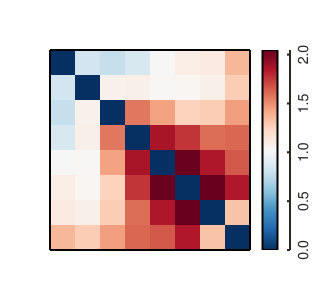

In [276]:
plot_matrix(var_test, color_bar=True)

In [268]:
var_test

array([[0.        , 0.83487931, 0.84363827, 0.8334506 , 0.88947276,
        0.95907964, 0.98148577, 1.14540489],
       [0.83487931, 0.        , 1.29554207, 1.1524514 , 0.96837109,
        0.9531476 , 0.98089104, 1.12303218],
       [0.84363827, 1.29554207, 0.        , 1.73572881, 1.48885979,
        1.28525765, 1.19066221, 1.29578758],
       [0.8334506 , 1.1524514 , 1.73572881, 0.        , 2.0052765 ,
        1.73473517, 1.43061009, 1.51600297],
       [0.88947276, 0.96837109, 1.48885979, 2.0052765 , 0.        ,
        2.01382679, 1.68318639, 1.57825075],
       [0.95907964, 0.9531476 , 1.28525765, 1.73473517, 2.01382679,
        0.        , 1.81901665, 1.549745  ],
       [0.98148577, 0.98089104, 1.19066221, 1.43061009, 1.68318639,
        1.81901665, 0.        , 0.9917659 ],
       [1.14540489, 1.12303218, 1.29578758, 1.51600297, 1.57825075,
        1.549745  , 0.9917659 , 0.        ]])

In [227]:
toyplot.matrix(arr_test.var(axis=0))

(<toyplot.canvas.Canvas at 0x7fb025fd5ad0>,
 <toyplot.coordinates.Table at 0x7f8bf27fac10>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="600px" height="600px" viewBox="0 0 600 600" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t33bfd7dcf1604195a993b0f948187de7"> 0 1 2 3 4 5 6 7 0 0.000000 0.198234 0.249983 0.823037 0.471546 1.349093 0.908523 0.908523 1 0.198234 0.000000 0.412298 0.103438 0.477426 0.837084 1.126328 1.126328 2 0.249983 0.412298 0.000000 0.227131 0.848503 0.471546 0.899984 0.899984 3 0.823037 0.103438 0.227131 0.000000 0.248840 1.806146 1.416018 1.416018 4 0.471546 0.477426 0.848503 0.248840 0.000000 3.320227 2.395029 2.395029 5 1.349093 0.837084 0.471546 1.806146 3.320227 0.000000 0.930945 0.930945 6 0.908523 1.126328 0.899984 1.416018 2.395029 0.930945 0.000000 0.000000 7 0.908523 1.126328 0.899984 1.416018 2.395029 0.930945 0.000000 0.000000

## Compute weighted lengths & create heatmap plots

- sim params: nsites = 2kb, 10kb, 100kb
- `batch_sims(baltree_2_gt, nloci=10,000, nsites=2_000, njobs=20, nthreads=2, infer=False)`

### BALANCED

### Balanced Variable gt - 2KB

In [91]:
variable_gt_2K, _ = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=2_000, njobs=20, nthreads=2, infer=False)
variable_gt_2K.to_csv("./nb9_output/variable_gt_2K_bal.csv")

In [92]:
variable_gt_2K = pd.read_csv("./nb9_output/variable_gt_2K_bal.csv", index_col=0)

In [93]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_gt_2K, 2000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_gt_2K_bal.csv")

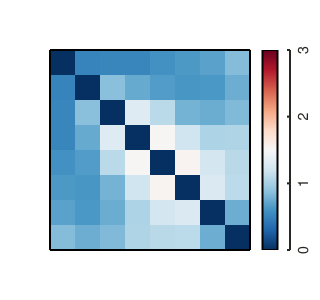

In [190]:
var_mean_variable_gt_2K = pd.read_csv("./nb9_output/var_mean_variable_gt_2K_bal.csv", index_col=0)
c = plot_matrix(var_mean_variable_gt_2K.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_gt_2K_bal.svg")
c

### Balanced Variable gt - 10KB

In [94]:
variable_gt_10K, _ = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=2, infer=False)
variable_gt_10K.to_csv("./nb9_output/variable_gt_10K_bal.csv")

In [95]:
variable_gt_10K = pd.read_csv("./nb9_output/variable_gt_10K_bal.csv", index_col=0)

In [96]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_gt_10K, 10000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_gt_10K_bal.csv")

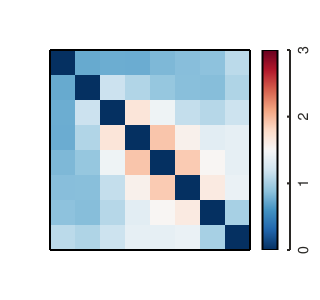

In [191]:
var_mean_variable_gt_10K = pd.read_csv("./nb9_output/var_mean_variable_gt_10K_bal.csv", index_col=0)
c = plot_matrix(var_mean_variable_gt_10K.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_gt_10K_bal.svg")
c

### Balanced Variable gt - 100KB

In [101]:
variable_gt_100K, _ = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=100_000, njobs=20, nthreads=2, infer=False)
variable_gt_100K.to_csv("./nb9_output/variable_gt_100K_bal.csv")

In [102]:
variable_gt_100K = pd.read_csv("./nb9_output/variable_gt_100K_bal.csv", index_col=0)

In [103]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_gt_100K, 100000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_gt_100K_bal.csv")

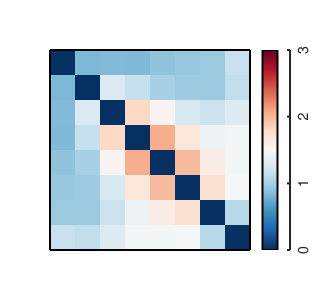

In [192]:
var_mean_variable_gt_100K = pd.read_csv("./nb9_output/var_mean_variable_gt_100K_bal.csv", index_col=0)
c = plot_matrix(var_mean_variable_gt_100K.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_gt_100K_bal.svg")
c

### Balanced Variable Ne - 2KB

In [105]:
variable_ne_2K, _ = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=2_000, njobs=20, nthreads=2, infer=False)
variable_ne_2K.to_csv("./nb9_output/variable_ne_2K_bal.csv")

In [106]:
variable_ne_2K = pd.read_csv("./nb9_output/variable_ne_2K_bal.csv", index_col=0)

In [107]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_ne_2K, 2000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_ne_2K_bal.csv")

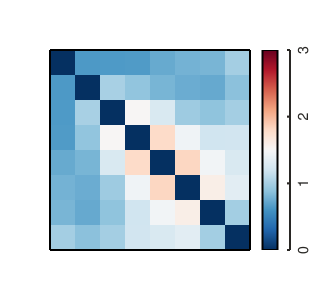

In [193]:
var_mean_variable_ne_2K = pd.read_csv("./nb9_output/var_mean_variable_ne_2K_bal.csv", index_col=0)
c = plot_matrix(var_mean_variable_ne_2K.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_ne_2K_bal.svg")
c

### Balanced Variable Ne - 10KB

In [109]:
variable_ne_10K, _ = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=2, infer=False)
variable_ne_10K.to_csv("./nb9_output/variable_ne_10K_bal.csv")

In [110]:
variable_ne_10K = pd.read_csv("./nb9_output/variable_ne_10K_bal.csv", index_col=0)

In [114]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_ne_10K, 10000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_ne_10K_bal.csv")

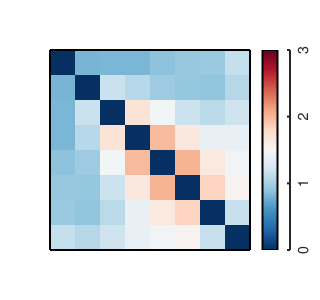

In [194]:
var_mean_variable_ne_10K = pd.read_csv("./nb9_output/var_mean_variable_ne_10K_bal.csv", index_col=0)
c = plot_matrix(var_mean_variable_ne_10K.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_ne_10K_bal.svg")
c

### Balanced Variable Ne - 100KB

In [116]:
variable_ne_100K, _ = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=100_000, njobs=20, nthreads=2, infer=False)
variable_ne_100K.to_csv("./nb9_output/variable_ne_100K_bal.csv")

In [117]:
variable_ne_10K = pd.read_csv("./nb9_output/variable_ne_100K_bal.csv", index_col=0)

In [ ]:
# ANALYSIS COMPLETE
arr, mean, shape = weighted_lengths_optimized_mean(variable_ne_100K, 100000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_ne_100K_bal.csv")

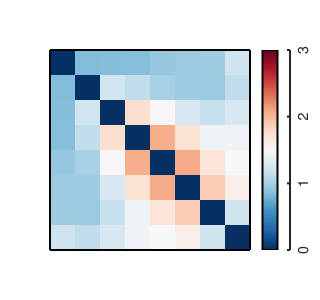

In [195]:
var_mean_variable_ne_100K = pd.read_csv("./nb9_output/var_mean_variable_ne_100K_bal.csv", index_col=0)
c = plot_matrix(var_mean_variable_ne_100K.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_ne_100K_bal.svg")
c

### IMBALANCED

### Imbalanced Variable gt - 2KB

In [123]:
variable_gt_2K_imb, _ = batch_sims(imbtree_gt, nloci=NLOCI, nsites=2_000, njobs=20, nthreads=2, infer=False)
variable_gt_2K_imb.to_csv("./nb9_output/variable_gt_2K_imb.csv")

In [125]:
variable_gt_2K_imb = pd.read_csv("./nb9_output/variable_gt_2K_imb.csv", index_col=0)

In [126]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_gt_2K_imb, 2000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_gt_2K_imb.csv")

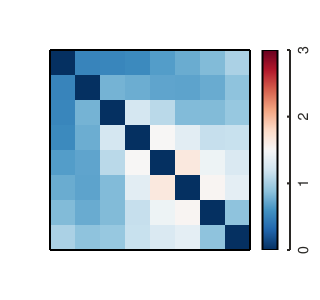

In [127]:
var_mean_variable_gt_2K_imb = pd.read_csv("./nb9_output/var_mean_variable_gt_2K_imb.csv", index_col=0)
c = plot_matrix(var_mean_variable_gt_2K_imb.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_gt_2K_imb.svg")
c

### Imbalanced Variable gt - 10KB

In [128]:
variable_gt_10K_imb, _ = batch_sims(imbtree_gt, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=2, infer=False)
variable_gt_10K_imb.to_csv("./nb9_output/variable_gt_10K_imb.csv")

In [129]:
variable_gt_10K_imb = pd.read_csv("./nb9_output/variable_gt_10K_imb.csv", index_col=0)

In [130]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_gt_10K_imb, 10000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_gt_10K_imb.csv")

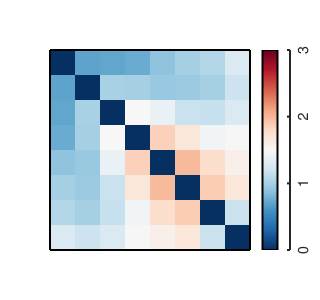

In [131]:
var_mean_variable_gt_10K_imb = pd.read_csv("./nb9_output/var_mean_variable_gt_10K_imb.csv", index_col=0)
c = plot_matrix(var_mean_variable_gt_10K_imb.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_gt_10K_imb.svg")
c

### Imbalanced Variable gt - 100KB

In [132]:
variable_gt_100K_imb, _ = batch_sims(imbtree_gt, nloci=NLOCI, nsites=100_000, njobs=20, nthreads=2, infer=False)
variable_gt_100K_imb.to_csv("./nb9_output/variable_gt_100K_imb.csv")

In [133]:
variable_gt_100K_imb = pd.read_csv("./nb9_output/variable_gt_100K_imb.csv", index_col=0)

In [134]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_gt_100K_imb, 100000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_gt_100K_imb.csv")

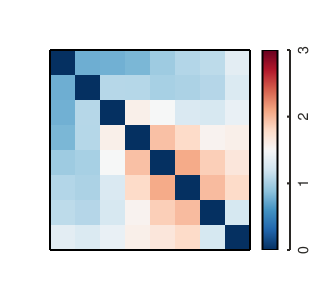

In [135]:
var_mean_variable_gt_100K_imb = pd.read_csv("./nb9_output/var_mean_variable_gt_100K_imb.csv", index_col=0)
c = plot_matrix(var_mean_variable_gt_100K_imb.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_gt_100K_imb.svg")
c

### Imbalanced Variable Ne - 2KB

In [136]:
variable_ne_2K_imb, _ = batch_sims(imbtree_ne, nloci=NLOCI, nsites=2_000, njobs=20, nthreads=2, infer=False)
variable_ne_2K_imb.to_csv("./nb9_output/variable_ne_2K_imb.csv")

In [137]:
variable_ne_2K_imb = pd.read_csv("./nb9_output/variable_ne_2K_imb.csv", index_col=0)

In [138]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_ne_2K_imb, 2000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_ne_2K_imb.csv")

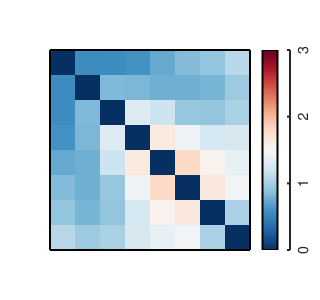

In [139]:
var_mean_variable_ne_2K_imb = pd.read_csv("./nb9_output/var_mean_variable_ne_2K_imb.csv", index_col=0)
c = plot_matrix(var_mean_variable_ne_2K_imb.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_ne_2K_imb.svg")
c

### Imbalanced Variable Ne - 10KB

In [140]:
variable_ne_10K_imb, _ = batch_sims(imbtree_ne, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=2, infer=False)
variable_ne_10K_imb.to_csv("./nb9_output/variable_ne_10K_imb.csv")

In [141]:
variable_ne_10K_imb = pd.read_csv("./nb9_output/variable_ne_10K_imb.csv", index_col=0)

In [142]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_ne_10K_imb, 10000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_ne_10K_imb.csv")

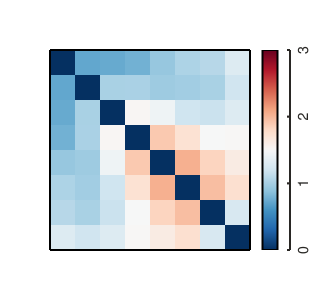

In [143]:
var_mean_variable_ne_10K_imb = pd.read_csv("./nb9_output/var_mean_variable_ne_10K_imb.csv", index_col=0)
c = plot_matrix(var_mean_variable_ne_10K_imb.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_ne_10K_imb.svg")
c

### Imbalanced Variable Ne - 100KB

In [144]:
variable_ne_100K_imb, _ = batch_sims(imbtree_ne, nloci=NLOCI, nsites=100_000, njobs=20, nthreads=2, infer=False)
variable_ne_100K_imb.to_csv("./nb9_output/variable_ne_100K_imb.csv")

In [145]:
variable_ne_100K_imb = pd.read_csv("./nb9_output/variable_ne_100K_imb.csv", index_col=0)

In [146]:
arr, mean, shape = weighted_lengths_optimized_mean(variable_ne_100K_imb, 100000)
pd.DataFrame(mean).to_csv("./nb9_output/var_mean_variable_ne_100K_imb.csv")

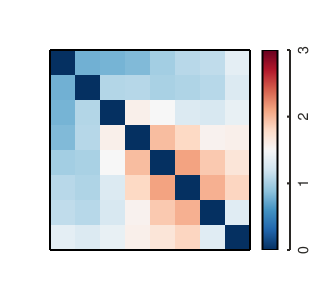

In [147]:
var_mean_variable_ne_100K_imb = pd.read_csv("./nb9_output/var_mean_variable_ne_100K_imb.csv", index_col=0)
c = plot_matrix(var_mean_variable_ne_100K_imb.values, color_bar=True, domain_max=3);
toyplot.svg.render(c, "./nb9_output/var_mean_variable_ne_100K_imb.svg")
c

## Variance difference figures (2Kb - 100Kb)

### Balanced Variable ne 2Kb - 100Kb

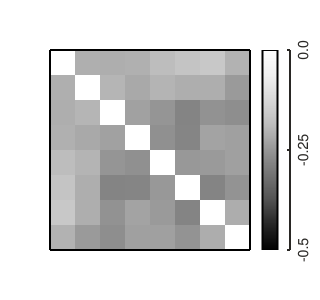

In [215]:
diff = (var_mean_variable_ne_2K.values - var_mean_variable_ne_100K.values)
c = plot_matrix(diff, color_bar=True, domain_min=-0.5, domain_max=0, cmap="Greys");
toyplot.svg.render(c, "./nb9_output/var-mean-variable-ne-linked-100K_2K-diff-bal.svg")
c

In [216]:
diff

array([[ 0.        , -0.20948174, -0.21193869, -0.20774853, -0.18684742,
        -0.17301677, -0.16215147, -0.2046977 ],
       [-0.20948174,  0.        , -0.20120904, -0.22024904, -0.20168608,
        -0.21117603, -0.21114666, -0.24383008],
       [-0.21193869, -0.20120904,  0.        , -0.23303315, -0.25183933,
        -0.2822405 , -0.256762  , -0.26471038],
       [-0.20774853, -0.22024904, -0.23303315,  0.        , -0.26122567,
        -0.28112909, -0.22843726, -0.2333314 ],
       [-0.18684742, -0.20168608, -0.25183933, -0.26122567,  0.        ,
        -0.24666134, -0.24400845, -0.23321214],
       [-0.17301677, -0.21117603, -0.2822405 , -0.28112909, -0.24666134,
         0.        , -0.28300037, -0.2559575 ],
       [-0.16215147, -0.21114666, -0.256762  , -0.22843726, -0.24400845,
        -0.28300037,  0.        , -0.21335308],
       [-0.2046977 , -0.24383008, -0.26471038, -0.2333314 , -0.23321214,
        -0.2559575 , -0.21335308,  0.        ]])

### Balanced Variable gt 2Kb - 100Kb

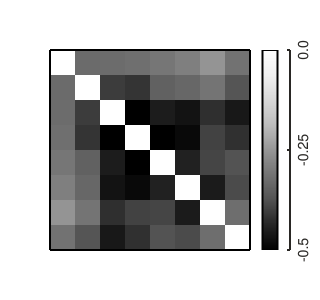

In [219]:
diff = (var_mean_variable_gt_2K.values - var_mean_variable_gt_100K.values)
c = plot_matrix(diff, color_bar=True, domain_min=-0.5, domain_max=0, cmap="Greys");
toyplot.svg.render(c, "./nb9_output/var-mean-variable-gt-linked-100K_2K-diff-bal.svg")
c

In [220]:
diff

array([[ 0.        , -0.32762551, -0.32608399, -0.31986524, -0.30735792,
        -0.29037796, -0.25310391, -0.31495923],
       [-0.32762551,  0.        , -0.40611265, -0.41669996, -0.34648788,
        -0.33511321, -0.31119496, -0.36921443],
       [-0.32608399, -0.40611265,  0.        , -0.49936937, -0.45262303,
        -0.46737862, -0.42328465, -0.45898412],
       [-0.31986524, -0.41669996, -0.49936937,  0.        , -0.52727104,
        -0.48424429, -0.39721322, -0.42253945],
       [-0.30735792, -0.34648788, -0.45262303, -0.52727104,  0.        ,
        -0.44342358, -0.39354729, -0.37376545],
       [-0.29037796, -0.33511321, -0.46737862, -0.48424429, -0.44342358,
         0.        , -0.45527518, -0.38447112],
       [-0.25310391, -0.31119496, -0.42328465, -0.39721322, -0.39354729,
        -0.45527518,  0.        , -0.32154139],
       [-0.31495923, -0.36921443, -0.45898412, -0.42253945, -0.37376545,
        -0.38447112, -0.32154139,  0.        ]])

### Imbalanced Variable ne 2Kb - 100Kb

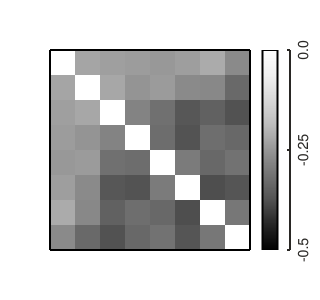

In [221]:
diff = (var_mean_variable_ne_2K_imb.values - var_mean_variable_ne_100K_imb.values)
c = plot_matrix(diff, color_bar=True, domain_min=-0.5, domain_max=0, cmap="Greys");
toyplot.svg.render(c, "./nb9_output/var-mean-variable-ne-linked-100K_2K-diff-imb.svg")
c

In [222]:
diff

array([[ 0.        , -0.22541848, -0.23490636, -0.24102909, -0.24629813,
        -0.23692987, -0.21638225, -0.27061237],
       [-0.22541848,  0.        , -0.2227587 , -0.2536185 , -0.24168184,
        -0.27061343, -0.27533152, -0.33073261],
       [-0.23490636, -0.2227587 ,  0.        , -0.28408353, -0.31881488,
        -0.36585181, -0.34566192, -0.37520216],
       [-0.24102909, -0.2536185 , -0.28408353,  0.        , -0.32373208,
        -0.37215965, -0.32276758, -0.33316277],
       [-0.24629813, -0.24168184, -0.31881488, -0.32373208,  0.        ,
        -0.2986085 , -0.33445787, -0.31350784],
       [-0.23692987, -0.27061343, -0.36585181, -0.37215965, -0.2986085 ,
         0.        , -0.3799848 , -0.36857717],
       [-0.21638225, -0.27533152, -0.34566192, -0.32276758, -0.33445787,
        -0.3799848 ,  0.        , -0.30464938],
       [-0.27061237, -0.33073261, -0.37520216, -0.33316277, -0.31350784,
        -0.36857717, -0.30464938,  0.        ]])

### Imbalanced Variable gt 2Kb - 100Kb

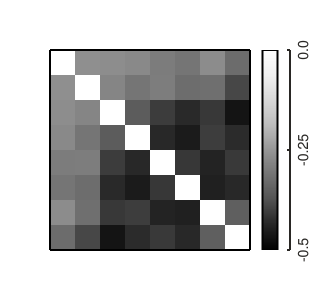

In [223]:
diff = (var_mean_variable_gt_2K_imb.values - var_mean_variable_gt_100K_imb.values)
c = plot_matrix(diff, color_bar=True, domain_min=-0.5, domain_max=0, cmap="Greys");
toyplot.svg.render(c, "./nb9_output/var-mean-variable-gt-linked-100K_2K-diff-imb.svg")
c

In [224]:
diff

array([[ 0.        , -0.26246685, -0.26605324, -0.27340196, -0.29559715,
        -0.30906465, -0.26773313, -0.3252788 ],
       [-0.26246685,  0.        , -0.28128088, -0.30987298, -0.2938154 ,
        -0.32478475, -0.31918512, -0.39073633],
       [-0.26605324, -0.28128088,  0.        , -0.35678454, -0.40517783,
        -0.4322144 , -0.41109523, -0.46560811],
       [-0.27340196, -0.30987298, -0.35678454,  0.        , -0.43304601,
        -0.45493915, -0.40463837, -0.42880263],
       [-0.29559715, -0.2938154 , -0.40517783, -0.43304601,  0.        ,
        -0.41243187, -0.44088105, -0.4092117 ],
       [-0.30906465, -0.32478475, -0.4322144 , -0.45493915, -0.41243187,
         0.        , -0.44529155, -0.43398133],
       [-0.26773313, -0.31918512, -0.41109523, -0.40463837, -0.44088105,
        -0.44529155,  0.        , -0.35076353],
       [-0.3252788 , -0.39073633, -0.46560811, -0.42880263, -0.4092117 ,
        -0.43398133, -0.35076353,  0.        ]])